In [1]:
### 입력으로 상호명을 받으면 업종분류를 반환하는 프로그램

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import time
import os

from tqdm import tqdm
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from transformers import BertTokenizerFast, BertConfig, BertModel # Bert 모델과 토크나이저
from torch.utils.data import Dataset, DataLoader
from collections import Counter

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

c:\code\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.init()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.reset_peak_memory_stats(device=None)
print("현재 디바이스:", device)

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

현재 디바이스: cuda


In [3]:
# 전처리된 CSV 파일 로드
def load_processed_data(file_path):
    """
    처리된 CSV 파일을 로드하는 함수
    """
    df = pd.read_csv(file_path)
    print(f"로드된 데이터 크기: {df.shape}")
    print(f"컬럼 목록: {df.columns.tolist()}")
    
    # 필요한 열만 추출 (업체명과 클래스)
    result_df = df[['상호명_Regulated', '클래스']].copy()
    
    # 컬럼명 통일
    result_df.columns = ['store', 'class']
    
    print(f"전처리 후 데이터 크기: {result_df.shape}")
    return result_df

In [4]:
data_df = load_processed_data('./processed_data/region_all_processed_data.csv')

로드된 데이터 크기: (1818487, 5)
컬럼 목록: ['상가업소번호', '지역', '상호명_Regulated', '업종소분류_Regulated', '클래스']
전처리 후 데이터 크기: (1818487, 2)


In [5]:
def split_dataset(df, test_size=0.2, random_state=42):
    """
    데이터를 훈련용과 테스트용으로 분할하는 함수
    """
    # 클래스 분포 확인
    num_classes = df['class'].nunique()
    print(f"고유 클래스 수: {num_classes}")
    
    # 데이터셋 분할 (stratify로 클래스 분포 유지)
    train_df, test_df = train_test_split(
        df, 
        test_size=test_size, 
        random_state=random_state,
        stratify=df['class']
    )
    
    print(f"훈련 데이터 크기: {train_df.shape}")
    print(f"테스트 데이터 크기: {test_df.shape}")

    return train_df, test_df

In [6]:
train_df, test_df = split_dataset(data_df)

고유 클래스 수: 247
훈련 데이터 크기: (1454789, 2)
테스트 데이터 크기: (363698, 2)


In [21]:
# 클래스별 샘플 수 세기
class_counts = Counter(train_df['class'])
num_classes = len(class_counts)
# 클래스 인덱스 매핑
class_to_idx = {cls: i for i, cls in enumerate(sorted(class_counts.keys()))}

In [7]:
train_df
# test_df

,store,class
1607566,드림아트,80
1385651,온가족국수,35
313687,알로하훌라스튜디오,76
1811134,전자담배라미야김제점,117
1391266,몽키리코에프엔비완주봉동지점,214
...,...,...
354405,크린토피아홈플러스서,123
798530,신한철물,207
1446488,갈목철공소,11
971736,이사랑서울치과의원,211


In [8]:
train_df.groupby(by=['class']).count()

,store
class,
0,4147
1,6031
2,582
3,2262
4,1308
...,...
242,1275
243,734
244,14120


In [9]:
tokenizer = BertTokenizerFast.from_pretrained('kykim/bert-kor-base')
token1 = tokenizer.tokenize("봉암쇼핑")
token2 = tokenizer.tokenize("밀사랑손칼국수")
token3 = tokenizer.tokenize("태민건축적산사무소")
token4 = tokenizer.tokenize("스타벅스R리저브강남대로점")
token5 = tokenizer.tokenize("로그인커피")
token6 = tokenizer.tokenize("스타벅스R리저브강남속편한치과건너편점")
print(token1, token2, token3, token4, token5, token6)

mecab = Mecab(dicpath='C:/mecab/mecab-ko-dic')
token1 = mecab.morphs("봉암쇼핑")
token2 = mecab.morphs("밀사랑손칼국수")
token3 = mecab.morphs("태민건축적산사무소")
token4 = mecab.morphs("스타벅스R리저브강남대로점")
token5 = mecab.morphs("로그인커피")
token6 = mecab.morphs("스타벅스R리저브강남속편한치과건너편점")
print(token1, token2, token3, token4, token5, token6)

['봉', '##암', '##쇼핑'] ['밀', '##사랑', '##손', '##칼국수'] ['태', '##민', '##건축', '##적', '##산', '##사무소'] ['스타벅스', '##r', '##리', '##저', '##브', '##강', '##남', '##대로', '##점'] ['로그인', '##커피'] ['스타벅스', '##r', '##리', '##저', '##브', '##강', '##남', '##속', '##편한', '##치', '##과', '##건', '##너', '##편', '##점']
['봉암', '쇼핑'] ['밀사', '랑', '손칼국수'] ['태민', '건축', '적', '산', '사무소'] ['스타', '벅스', 'R', '리저브', '강남대로', '점'] ['로그인', '커피'] ['스타', '벅스', 'R', '리저브', '강남', '속편', '한', '치과', '건너편', '점']


In [10]:
class TokenDataset(Dataset):
    def __init__(self, dataframe, tokenizer_pretrained):
        # sentence, label 컬럼으로 구성된 데이터프레임 전달
        self.data = dataframe        
        # Huggingface 토크나이저 생성
        self.tokenizer = BertTokenizerFast.from_pretrained(tokenizer_pretrained)
  
    def __len__(self):
        return len(self.data)
  
    def __getitem__(self, idx):
        sentence = self.data.iloc[idx]['store']
        label = self.data.iloc[idx]['class']

        # 토큰화 처리
        tokens = self.tokenizer(
            str(sentence),                # 1개 문장 
            return_tensors='pt',     # 텐서로 반환
            truncation=True,         # 잘라내기 적용
            padding='max_length',    # 패딩 적용
            max_length=60,          # 최대 길이 60
            add_special_tokens=True  # 스페셜 토큰 적용
        )

        input_ids = tokens['input_ids'].squeeze(0)           # 2D -> 1D
        attention_mask = tokens['attention_mask'].squeeze(0) # 2D -> 1D
        token_type_ids = torch.zeros_like(attention_mask)

        # input_ids, attention_mask, token_type_ids 이렇게 3가지 요소를 반환하도록 합니다.
        # input_ids: 토큰
        # attention_mask: 실제 단어가 존재하면 1, 패딩이면 0 (패딩은 0이 아닐 수 있습니다)
        # token_type_ids: 문장을 구분하는 id. 단일 문장인 경우에는 전부 0
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask, 
            'token_type_ids': token_type_ids,
        }, torch.tensor(label)

In [11]:
train_data = TokenDataset(train_df, 'kykim/bert-kor-base')
test_data = TokenDataset(test_df, 'kykim/bert-kor-base')

# DataLoader로 이전에 생성한 Dataset를 지정하여, batch 구성, shuffle, num_workers 등을 설정합니다.
train_loader = DataLoader(train_data, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=0)

In [12]:
# 1개의 batch 꺼내기
inputs, labels = next(iter(train_loader))

# 데이터셋을 device 설정
inputs = {k: v.to(device) for k, v in inputs.items()}
labels.to(device)

tensor([ 80,  35,  76, 117, 214, 213, 214,  66, 107,  33, 153, 150,  80,  60,
        183, 103, 214, 180,  18,  74, 214,  87, 228, 107, 112,  18,  91,  87,
         55,   6,  55, 127,  34, 184,  72, 231, 204, 147, 157,  55, 212, 214,
         34, 204,  11,  60,  80, 112, 214,  87, 134,  41,  66, 214, 241, 241,
        228,  91, 229, 216, 124,  85,  74, 103], device='cuda:0')

In [22]:
class BertCNNModel(nn.Module):
    def __init__(self, bert_pretrained, num_classes=247, dropout_rate=0.3, kernel_sizes=[2,3,4], num_filters=128):
        super().__init__()
        self.bert = BertModel.from_pretrained(bert_pretrained)
        self.convs = nn.ModuleList([
            nn.Conv1d(768, num_filters, k) for k in kernel_sizes
        ])
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        x = outputs['last_hidden_state'].transpose(1, 2)  # [batch, 768, seq_len]
        conv_outs = [F.relu(conv(x)) for conv in self.convs]
        pooled = [F.max_pool1d(c, c.size(2)).squeeze(2) for c in conv_outs]
        cat = torch.cat(pooled, dim=1)
        cat = self.dropout(cat)
        logits = self.fc(cat)
        return logits

In [23]:
tokenizer_pretrained = 'kykim/bert-kor-base'
bert_tokenizer = BertTokenizerFast.from_pretrained(tokenizer_pretrained)
bert = BertCNNModel(tokenizer_pretrained, num_classes=len(class_to_idx)).to(device)
bert.to(device)

BertCNNModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(42000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [24]:
# loss 정의: CrossEntropyLoss
loss_fn = nn.CrossEntropyLoss()

# 옵티마이저 정의: bert.paramters()와 learning_rate 설정
optimizer = optim.Adam(bert.parameters(), lr=1e-5)

In [3]:
model_name = 'bert-kor-cnn_all'
time_date = '2505081630'
save_path = f'./saved_model/{model_name}_{time_date}'

In [26]:
bert.load_state_dict(torch.load(save_path + f'/{model_name}_{time_date}.pth'))

<All keys matched successfully>

In [27]:
tokenizer = BertTokenizerFast.from_pretrained('kykim/bert-kor-base')
labels = pickle.load(open('./processed_data/category_mapping.pkl', 'rb'))
labels = {v: k for k, v in labels.items()}
labels

{'0': 'PC방',
 '1': '가구',
 '2': '가발',
 '3': '가방',
 '4': '가스 충전소',
 '5': '가전제품',
 '6': '가전제품 수리',
 '7': '가정용 연료',
 '8': '가죽/가방/신발 수선',
 '9': '가축 사료',
 '10': '간이 음식점(기타)',
 '11': '개인/가정용품 수리(기타)',
 '12': '건강보조식품',
 '13': '건물 및 토목 엔지니어링 서비스',
 '14': '건설/건축자재',
 '15': '건설기계/장비 대여업',
 '16': '건어물/젓갈',
 '17': '건축 설계 및 관련 서비스',
 '18': '건축물 일반 청소',
 '19': '결혼 상담 서비스',
 '20': '경양식',
 '21': '경영 컨설팅',
 '22': '고용 알선업',
 '23': '곡물/곡분',
 '24': '골프 연습장',
 '25': '곱창 전골/구이',
 '26': '공인노무사',
 '27': '공인회계사',
 '28': '광고 대행',
 '29': '광고 매체 판매',
 '30': '광고물 설계/제작업',
 '31': '교육기관(기타)',
 '32': '교육컨설팅',
 '33': '구내식당',
 '34': '국/탕/찌개류',
 '35': '국수/칼국수',
 '36': '기념품점',
 '37': '기숙사/고시원',
 '38': '기타 개인/가정용품 대여업',
 '39': '기타 건설/건축자재',
 '40': '기타 광고 관련 서비스',
 '41': '기타 교육지원 서비스',
 '42': '기타 기술/직업 훈련학원',
 '43': '기타 동남아식 전문',
 '44': '기타 법무관련 서비스',
 '45': '기타 사무 지원 서비스',
 '46': '기타 산업용 기계/장비 대여업',
 '47': '기타 서양식 음식점',
 '48': '기타 스포츠시설 운영업',
 '49': '기타 엔지니어링 서비스',
 '50': '기타 여행 보조/예약 서비스',
 '51': '기타 예술/스포츠 교육기관',
 '52': 

In [28]:
class CustomPredictor():
    def __init__(self, model, tokenizer, labels: dict):
        self.model = model
        self.tokenizer = tokenizer
        self.labels = labels
        
    def predict(self, sentence):
        # 토큰화 처리
        tokens = self.tokenizer(
            str(sentence),                # 1개 문장 
            return_tensors='pt',     # 텐서로 반환
            truncation=True,         # 잘라내기 적용
            padding='max_length',    # 패딩 적용
            max_length=60,          # 최대 길이 60
            add_special_tokens=True  # 스페셜 토큰 적용
        )
        tokens.to(device)
        prediction = self.model(**tokens)
        prediction = F.softmax(prediction, dim=1)
        output = prediction.argmax(dim=1).item()
        prob = prediction.max(dim=1)[0].item() * 100
        result = self.labels[str(output)]
        return result, prob

In [31]:
predictor = CustomPredictor(bert, tokenizer, labels)

predict_time = 9999
for i in range(10):
    start_time = time.time()
    query = test_df.iloc[i]['store']
    pred, acc = predictor.predict(query)
    print(f'{query} -> {pred} ({acc:.2f}%)')
    end_time = time.time()
    elapsed_time = end_time - start_time
    if elapsed_time < predict_time:
        predict_time = elapsed_time
query = "스타벅스R리저브강남속편한치과건너편점"
pred = predictor.predict(query)
print(query, pred)
print(f"예측 소요 시간: {predict_time:.4f}초")

캐치캐치아이스 -> 전자 게임장 (11.47%)
아엠 -> 의류 대여업 (3.44%)
새틴 -> 실/섬유제품 (17.66%)
네일즈247 -> 네일숍 (94.77%)
커피랑도서관대구본동점 -> 만화방 (94.82%)
꿈꾸는요리사 -> 빵/도넛 (8.48%)
메타교육 -> 직원 훈련기관 (8.52%)
나선재 -> 한복 (12.42%)
평화이앤씨주 -> 환경 관련 엔지니어링 서비스 (24.01%)
약령 -> 마사지/안마 (17.53%)
스타벅스R리저브강남속편한치과건너편점 ('아이스크림/빙수', 67.8425133228302)
예측 소요 시간: 0.0120초


In [33]:
def batch_predict(model, dataloader, labels_dict, device, test_df):
    # 배치 단위로 예측 수행
    model.eval()
    results = []
    idx = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            batch_size = len(labels)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            # 예측 수행
            outputs = model(**inputs)
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            confidence = torch.max(probs, dim=1)[0]
            # 결과 저장
            for i in range(batch_size):
                pred_class = labels_dict[str(preds[i].item())]
                true_class = labels_dict[str(labels[i].item())]
                results.append({
                    'query': test_df.iloc[idx]['store'],
                    'pred': pred_class,
                    'label': true_class,
                    'prob': f'{confidence[i].item()*100:.2f}%'
                })
                idx += 1
    return pd.DataFrame(results)

# 평가용 데이터로더 설정 (배치 크기 증가)
test_loader = DataLoader(test_data, batch_size=256, shuffle=False, num_workers=0)

# 배치 예측 실행
test_query_df = batch_predict(bert, test_loader, labels, device, test_df)

100%|██████████| 1421/1421 [12:50<00:00,  1.84it/s]


In [34]:
test_query_df

,query,pred,label,prob
0,캐치캐치아이스,전자 게임장,슈퍼마켓,26.54%
1,아엠,패션/섬유/기타 전문 디자인업,명함/간판/광고물 제작,3.10%
2,새틴,가방,여관/모텔,15.90%
3,네일즈247,네일숍,네일숍,93.04%
4,커피랑도서관대구본동점,만화방,독서실/스터디 카페,96.40%
...,...,...,...,...
363693,천사차일드유,수영장,의류 대여업,54.17%
363694,녹십자요양병원,요양병원,요양병원,91.04%
363695,문화떡방앗간,떡/한과,떡/한과,99.23%
363696,타미진갤러리아센터시티,만화방,여성 의류,22.48%


In [35]:
score = test_query_df['pred'].eq(test_query_df['label']).sum() / len(test_query_df) * 100
score

np.float64(39.35682901748154)

In [36]:
# Error Analysis
error_df = test_query_df[test_query_df['pred'] != test_query_df['label']].copy()
error_df.head(20)

,query,pred,label,prob
0,캐치캐치아이스,전자 게임장,슈퍼마켓,26.54%
1,아엠,패션/섬유/기타 전문 디자인업,명함/간판/광고물 제작,3.10%
2,새틴,가방,여관/모텔,15.90%
4,커피랑도서관대구본동점,만화방,독서실/스터디 카페,96.40%
5,꿈꾸는요리사,간이 음식점(기타),빵/도넛,11.31%
6,메타교육,직원 훈련기관,요가/필라테스 학원,7.42%
7,나선재,한복,펜션,12.12%
8,평화이앤씨주,환경 관련 엔지니어링 서비스,건축 설계 및 관련 서비스,21.30%
9,약령,마사지/안마,경양식,11.22%
11,웅진NS,컴퓨터/사무기기 대여업,서점,28.50%


In [37]:
pickle.dump(test_query_df, open(f'./saved_model/{model_name}_{time_date}/test_query_df.pkl', 'wb'))
pickle.dump(error_df, open(f'./saved_model/{model_name}_{time_date}/error_df.pkl', 'wb'))

# Error 분석

In [4]:
test_query_df = pickle.load(open(f'./saved_model/{model_name}_{time_date}/test_query_df.pkl', 'rb'))
error_df = pickle.load(open(f'./saved_model/{model_name}_{time_date}/error_df.pkl', 'rb'))
error_df.head(20)

,query,pred,label,prob
0,캐치캐치아이스,전자 게임장,슈퍼마켓,26.54%
1,아엠,패션/섬유/기타 전문 디자인업,명함/간판/광고물 제작,3.10%
2,새틴,가방,여관/모텔,15.90%
4,커피랑도서관대구본동점,만화방,독서실/스터디 카페,96.40%
5,꿈꾸는요리사,간이 음식점(기타),빵/도넛,11.31%
6,메타교육,직원 훈련기관,요가/필라테스 학원,7.42%
7,나선재,한복,펜션,12.12%
8,평화이앤씨주,환경 관련 엔지니어링 서비스,건축 설계 및 관련 서비스,21.30%
9,약령,마사지/안마,경양식,11.22%
11,웅진NS,컴퓨터/사무기기 대여업,서점,28.50%


In [5]:
acc = test_query_df['pred'].eq(test_query_df['label']).sum() / len(test_query_df) * 100
print(f"Accuracy: {acc:.2f}%")

Accuracy: 39.36%


In [7]:
# sklearn classification_report로 정밀도, 재현율 등 계산
print(classification_report(test_query_df['label'], test_query_df['pred'], digits=4, zero_division=0))

                      precision    recall  f1-score   support

                 PC방     0.8407    0.8852    0.8624      1037
                  가구     0.7760    0.4894    0.6002      1508
                  가발     0.0076    0.3448    0.0149       145
                  가방     0.0866    0.4364    0.1445       566
              가스 충전소     0.4127    0.7951    0.5434       327
                가전제품     0.2828    0.2279    0.2524      1163
             가전제품 수리     0.6542    0.2744    0.3866      1662
              가정용 연료     0.6050    0.8011    0.6893       759
         가죽/가방/신발 수선     0.0264    0.5522    0.0504       134
               가축 사료     0.0198    0.4336    0.0380       256
          간이 음식점(기타)     0.0796    0.2958    0.1254      1153
      개인/가정용품 수리(기타)     0.4526    0.3296    0.3814      1247
              건강보조식품     0.7528    0.3407    0.4691      2351
   건물 및 토목 엔지니어링 서비스     0.4119    0.2259    0.2918      1160
             건설/건축자재     0.0796    0.6244    0.1412       197
       

In [41]:
macro_precision = precision_score(test_query_df['label'], test_query_df['pred'], average='macro')
macro_recall = recall_score(test_query_df['label'], test_query_df['pred'], average='macro')
print(f"Macro Precision: {macro_precision:.2f}, Macro Recall: {macro_recall:.2f}")

c:\code\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Macro Precision: 0.41, Macro Recall: 0.53


In [42]:
micro_precision = precision_score(test_query_df['label'], test_query_df['pred'], average='micro')
micro_recall = recall_score(test_query_df['label'], test_query_df['pred'], average='micro')
micro_f1 = f1_score(test_query_df['label'], test_query_df['pred'], average='micro')
print(f"Micro Precision: {micro_precision:.2f}, Micro Recall: {micro_recall:.2f}, Micro F1: {micro_f1:.2f}")

Micro Precision: 0.39, Micro Recall: 0.39, Micro F1: 0.39


In [43]:
error_case_counts = (
    error_df.groupby(['pred', 'label'])
    .size()
    .reset_index(name='count')
    .sort_values(by='count', ascending=False)
)
error_case_counts

,pred,label,count
13002,전문자격/고시학원,입시·교과학원,5282
11025,외국어학원,입시·교과학원,2907
169,가발,미용실,2700
15181,타이어,자동차 정비소,1866
9156,숙박업(기타),펜션,1823
...,...,...,...
20,PC방,수산물,1
19,PC방,사진촬영업,1
15,PC방,반찬/식료품,1
14,PC방,당구장,1


---

### Confusion matrix

In [44]:
unique_classes = sorted(test_query_df['label'].unique())
y_pred = test_query_df['pred'].values
y_true = test_query_df['label'].values
cm = confusion_matrix(y_true, y_pred, labels=unique_classes)
cm_df = pd.DataFrame(cm)

cm_df

,0,1,2,3,4,5,6,7,8,9,...,237,238,239,240,241,242,243,244,245,246
0,918,0,2,2,0,0,0,0,0,0,...,0,0,1,0,0,2,1,0,3,0
1,0,738,9,22,1,5,1,0,29,11,...,0,0,6,0,0,8,5,0,13,0
2,0,0,50,7,0,1,0,0,0,1,...,0,0,1,0,0,1,0,0,1,0
3,0,1,22,247,0,0,0,0,29,2,...,0,3,4,0,0,3,0,0,3,0
4,0,0,0,0,260,0,0,30,0,1,...,0,0,0,0,0,0,0,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,0,0,0,0,0,0,0,0,1,2,...,0,0,1,0,0,205,1,0,0,0
243,0,0,0,0,0,0,0,0,2,1,...,0,0,0,0,0,0,125,0,1,0
244,3,1,181,56,1,6,0,2,37,37,...,0,1,10,1,3,16,9,611,44,1
245,0,0,1,0,6,0,0,1,0,2,...,0,0,4,1,0,1,1,0,184,0


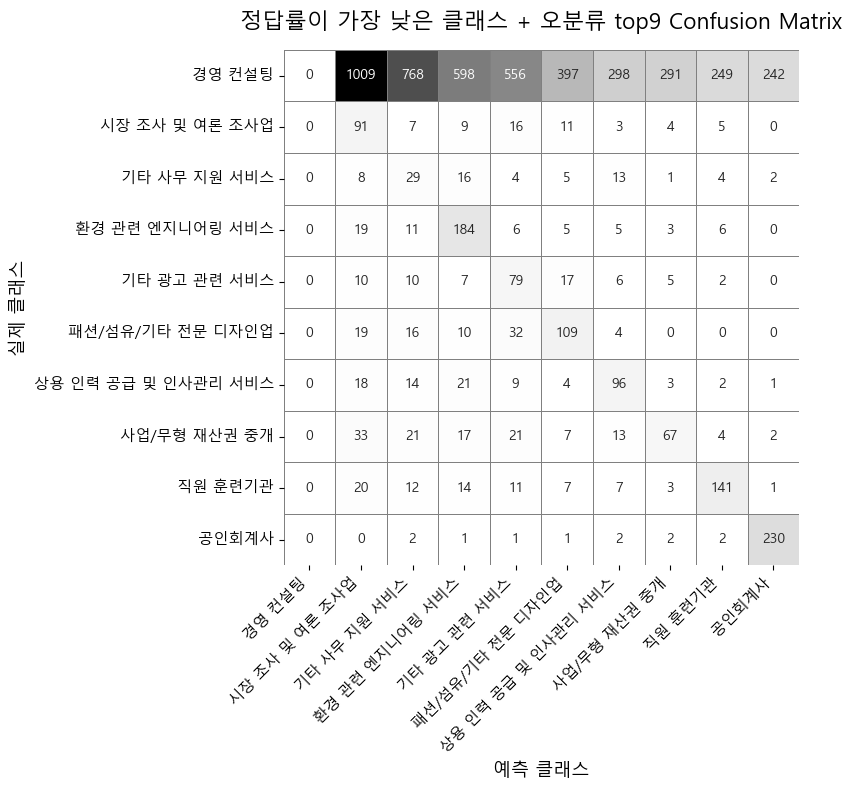

In [45]:
total_counts = cm.sum(axis=1)
correct_counts = np.diag(cm)
correct_ratio = correct_counts / (total_counts + 1e-8)

low_idx = np.argmin(correct_ratio)
low_class = unique_classes[low_idx]

row = cm[low_idx].copy()
row[low_idx] = 0
top9_wrong_idx = np.argsort(row)[-9:][::-1]

selected_idx = [low_idx] + list(top9_wrong_idx)
cm_sub = cm[np.ix_(selected_idx, selected_idx)]
class_labels = [unique_classes[i] for i in selected_idx]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_sub,
            annot=True,
            fmt='d',
            cmap='Greys',
            xticklabels=class_labels,
            yticklabels=class_labels,
            linewidths=0.5,
            linecolor='gray',
            cbar=False,
            square=True
            )
plt.title('정답률이 가장 낮은 클래스 + 오분류 top9 Confusion Matrix', fontsize=16, pad=15)
plt.xlabel('예측 클래스', fontsize=13)
plt.ylabel('실제 클래스', fontsize=13)
plt.xticks(fontsize=11, rotation=45, ha='right')
plt.yticks(fontsize=11, rotation=0)
plt.tight_layout()
plt.show()

In [46]:
error_case_ads_df = test_query_df[
    (test_query_df['label'] == '광고 매체 판매') &
    ((test_query_df['pred'] == '광고 대행') |
     (test_query_df['pred'] == '경영 컨설팅'))
    ]
error_case_ads_df

,query,pred,label,prob


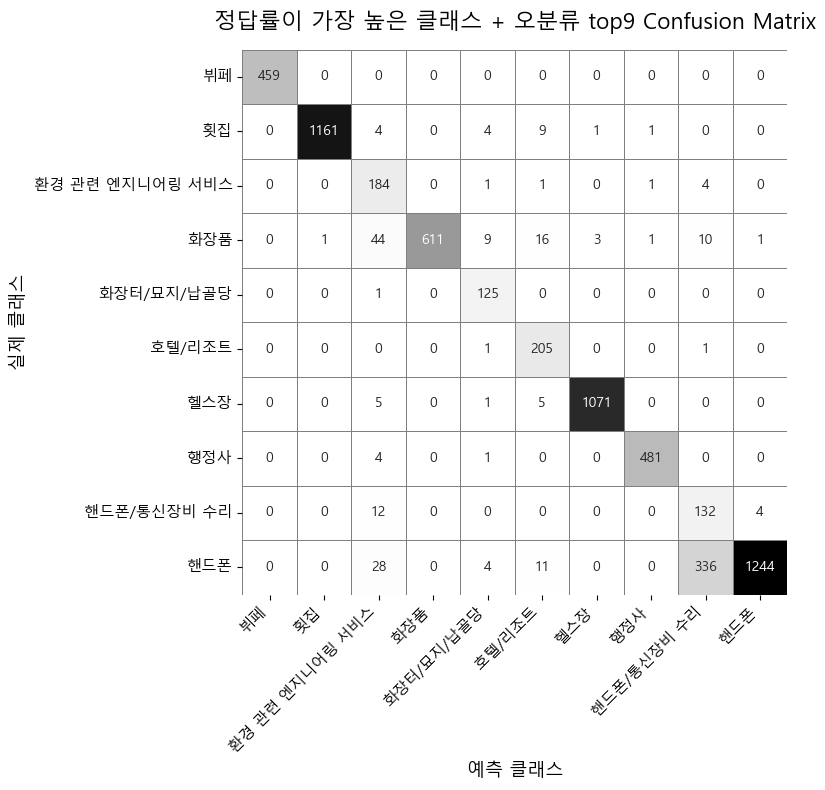

In [47]:
total_counts = cm.sum(axis=1)
correct_counts = np.diag(cm)
correct_ratio = correct_counts / (total_counts + 1e-8)

top_idx = np.argmax(correct_ratio)
top_class = unique_classes[top_idx]

row = cm[top_idx].copy()
row[top_idx] = 0  # 자기 자신 제외
top9_correct_idx = np.argsort(row)[-9:][::-1]

selected_idx = [top_idx] + list(top9_correct_idx)
cm_sub = cm[np.ix_(selected_idx, selected_idx)]
class_labels = [unique_classes[i] for i in selected_idx]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_sub,
            annot=True,
            fmt='d',
            cmap='Greys',
            xticklabels=class_labels,
            yticklabels=class_labels,
            linewidths=0.5,
            linecolor='gray',
            cbar=False,
            square=True
            )
plt.title('정답률이 가장 높은 클래스 + 오분류 top9 Confusion Matrix', fontsize=16, pad=15)
plt.xlabel('예측 클래스', fontsize=13)
plt.ylabel('실제 클래스', fontsize=13)
plt.xticks(fontsize=11, rotation=45, ha='right')
plt.yticks(fontsize=11, rotation=0)
plt.tight_layout()
plt.show()

In [48]:
error_case_pinpong_df = test_query_df[test_query_df['label'] == '탁구장']
error_case_pinpong_df

,query,pred,label,prob
595,무인탁구장탁구핑24,탁구장,탁구장,99.55%
1769,금천킹탁구클럽,탁구장,탁구장,99.92%
2005,평화어울림탁구클럽,탁구장,탁구장,99.95%
2470,생활체육탁구장,탁구장,탁구장,99.93%
2931,와우탁구장,탁구장,탁구장,99.94%
...,...,...,...,...
358322,허브탁구장,탁구장,탁구장,99.93%
359413,강경주탁구클럽,탁구장,탁구장,99.95%
360957,은평탁구체육관,탁구장,탁구장,78.80%
361111,봉하탁구교실,탁구장,탁구장,99.93%


In [49]:
def plot_nth_lowest_accuracy_confusion(cm, unique_classes, n=1, topk=9):
    """
    cm: confusion_matrix (numpy array)
    unique_classes: 클래스 이름 리스트 (confusion_matrix의 labels 순서와 동일)
    n: 정답률이 낮은 순서에서 n번째 (1부터 시작)
    topk: 오분류 top k개
    """
    total_counts = cm.sum(axis=1)
    correct_counts = np.diag(cm)
    correct_ratio = correct_counts / (total_counts + 1e-8)
    
    # 정답률 낮은 순서대로 인덱스 정렬
    sorted_idx = np.argsort(correct_ratio)
    nth_idx = sorted_idx[n-1]  # n=1이면 가장 낮은 클래스
    
    row = cm[nth_idx].copy()
    row[nth_idx] = 0  # 자기 자신 제외
    topk_wrong_idx = np.argsort(row)[-topk:][::-1]
    
    selected_idx = [nth_idx] + list(topk_wrong_idx)
    cm_sub = cm[np.ix_(selected_idx, selected_idx)]
    class_labels = [unique_classes[i] for i in selected_idx]
    
    if n <= 0:
        title = f'{abs(n)+1}번째로 정답률이 높은 클래스 + 오분류 top{topk} Confusion Matrix'
    else:
        title = f'{n+1}번째로 정답률이 낮은 클래스 + 오분류 top{topk} Confusion Matrix'
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_sub,
                annot=True,
                fmt='d',
                cmap='Greys',
                xticklabels=class_labels,
                yticklabels=class_labels,
                linewidths=0.5,
                linecolor='gray',
                cbar=False,
                square=True
                )
    plt.title(title, fontsize=16, pad=15)
    plt.xlabel('예측 클래스', fontsize=13)
    plt.ylabel('실제 클래스', fontsize=13)
    plt.xticks(fontsize=11, rotation=45, ha='right')
    plt.yticks(fontsize=11, rotation=0)
    plt.tight_layout()
    plt.show()

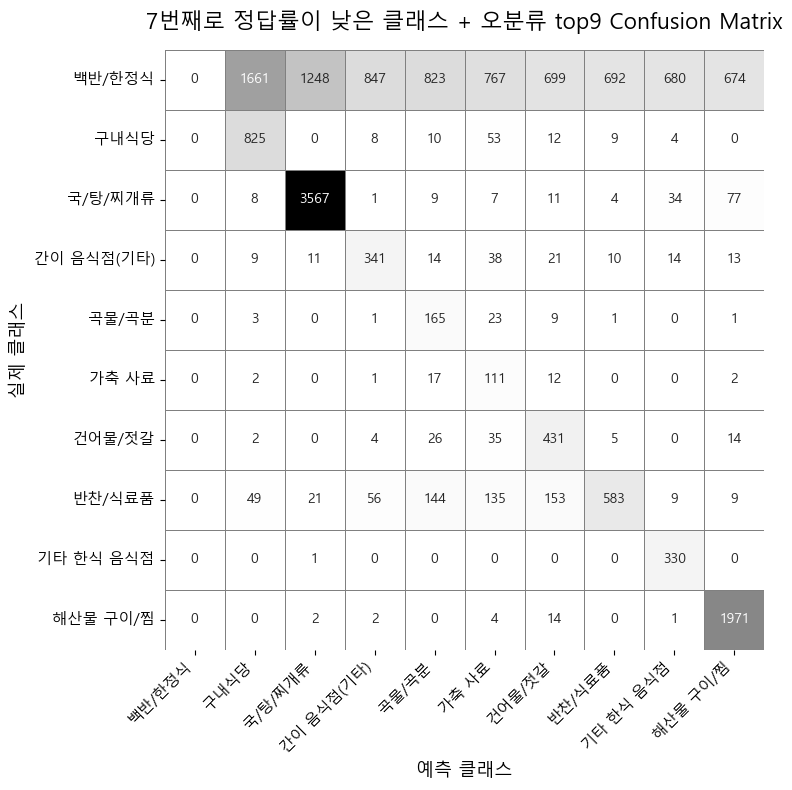

In [50]:
plot_nth_lowest_accuracy_confusion(cm, unique_classes, n=6, topk=9)

In [51]:
test_query_undefinedrestaurant_df = test_query_df[test_query_df['label'] == '분류 안된 외국식 음식점']
test_query_undefinedrestaurant_df

,query,pred,label,prob
3824,오한수우육면가상암,분류 안된 외국식 음식점,분류 안된 외국식 음식점,100.00%
48935,오한수우육면가강남삼성타운점,분류 안된 외국식 음식점,분류 안된 외국식 음식점,100.00%
172107,오한수우육면가씨티스퀘어,분류 안된 외국식 음식점,분류 안된 외국식 음식점,100.00%
277938,오한수우육면가오피시아점,분류 안된 외국식 음식점,분류 안된 외국식 음식점,100.00%
288368,우즈베키스탄레스토랑,분류 안된 외국식 음식점,분류 안된 외국식 음식점,100.00%
289321,잠잠우즈베키스탄레스토랑,분류 안된 외국식 음식점,분류 안된 외국식 음식점,99.99%


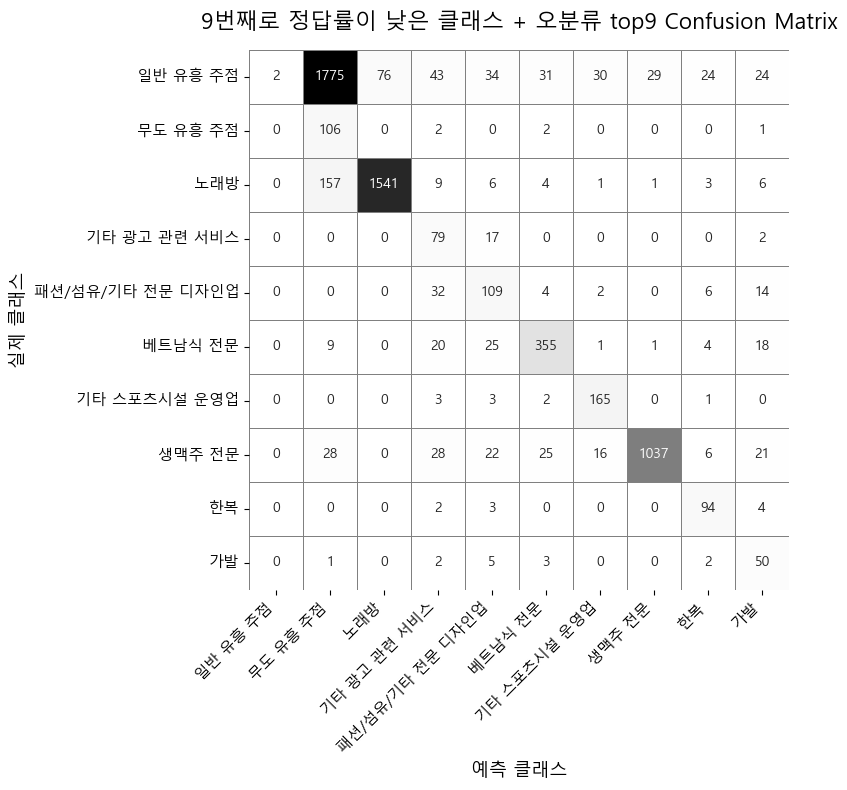

In [52]:
plot_nth_lowest_accuracy_confusion(cm, unique_classes, n=8, topk=9)

In [31]:
test_query_undefinedhotel_df = test_query_df[test_query_df['label'] == '숙박업(기타)']
test_query_undefinedhotel_df

,query,pred,label,prob
3363,늘품B,펜션,숙박업(기타),49.28%
12918,조은하숙,기숙사/고시원,숙박업(기타),64.11%
20221,DKS고시원,기숙사/고시원,숙박업(기타),98.67%
20700,한양HABITAT,자동차 정비소,숙박업(기타),18.32%
20787,가양레지던스,기숙사/고시원,숙박업(기타),86.74%
...,...,...,...,...
339191,장수투원빌,기숙사/고시원,숙박업(기타),43.69%
344405,속초스테이C동806a,펜션,숙박업(기타),92.79%
350292,채움관광농원,펜션,숙박업(기타),23.13%
350304,Gray29,여성 의류,숙박업(기타),35.48%


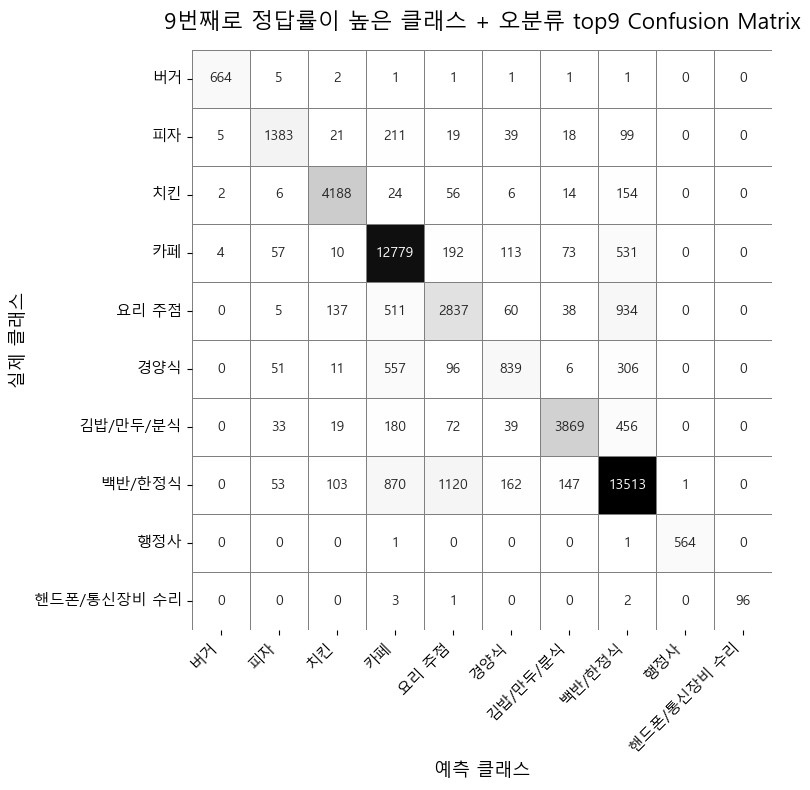

In [55]:
plot_nth_lowest_accuracy_confusion(cm, unique_classes, n=-8, topk=9)

In [60]:
test_query_burger_df = test_query_df[(test_query_df['label'] == '버거')]
error_case_burger_df = test_query_df[(test_query_df['label'] == '버거') & (test_query_df['pred'] != '버거')]
test_query_burger_df

,query,pred,label,prob
470,롯데리아청주,버거,버거,99.76%
542,롯데리아용인둔전점,버거,버거,99.85%
1783,롯데리아부산학장점,버거,버거,99.84%
2038,프랭크버거삼척,버거,버거,99.89%
2192,버거팩토리,버거,버거,99.40%
...,...,...,...,...
360383,버거또,버거,버거,99.37%
361901,스테이플버거,버거,버거,98.91%
362390,프랭크버거장승배기역점,버거,버거,99.89%
362614,맘스터치수지,버거,버거,99.89%


In [61]:
error_case_burger_df

,query,pred,label,prob
36790,승한유에프오버거안산,피자,버거,13.55%
49279,맥도날드대,피자,버거,74.00%
62176,칙바이칙,피자,버거,28.20%
84125,밀크밥버거카톨릭관,김밥/만두/분식,버거,96.38%
115517,오버거,카페,버거,12.32%
177453,맥도날드고양원당DT점,피자,버거,82.28%
191536,피치엔버거연천상리점,치킨,버거,80.69%
211452,데카에셋롯데리아안양관,피자,버거,64.67%
215541,버거앤취킨,치킨,버거,78.81%
285411,브로스키친,백반/한정식,버거,38.24%
